In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import PredictionErrorDisplay

import lightgbm as lgb

In [12]:
# Import data
obs_A = pd.read_parquet('../../preprocessing/data/obs_A.parquet')
obs_B = pd.read_parquet('../../preprocessing/data/obs_B.parquet')
obs_C = pd.read_parquet('../../preprocessing/data/obs_C.parquet')
est_A = pd.read_parquet('../../preprocessing/data/est_A.parquet')
est_B = pd.read_parquet('../../preprocessing/data/est_B.parquet')
est_C = pd.read_parquet('../../preprocessing/data/est_C.parquet')
test_A = pd.read_parquet('../../preprocessing/data/test_A.parquet').drop(columns='date_forecast')
test_B = pd.read_parquet('../../preprocessing/data/test_B.parquet').drop(columns='date_forecast')
test_C = pd.read_parquet('../../preprocessing/data/test_C.parquet').drop(columns='date_forecast')

In [3]:
# Concatinate
A = pd.concat([obs_A, est_A])
B = pd.concat([obs_B, est_B])
C = pd.concat([obs_C, est_C])

A.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in A.columns]
B.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in B.columns]
C.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in C.columns]

In [4]:
obs_A.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in obs_A.columns]
est_A.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in est_A.columns]
test_A.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in test_A.columns]

obs_B.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in obs_B.columns]
est_B.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in est_B.columns]
test_B.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in test_B.columns]

obs_C.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in obs_C.columns]
est_C.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in est_C.columns]
test_C.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in test_C.columns]

A = A[A['date_forecast'].dt.month.isin([4, 5, 6, 7, 8, 9])]
unique_days = A['date_forecast'].dt.date.unique()
sampled_days = np.random.choice(unique_days, size=int(len(unique_days) * 0.2), replace=False)
val_A = A[A['date_forecast'].dt.date.isin(sampled_days)]
train_A = A[~A['date_forecast'].dt.date.isin(sampled_days)]
X_train_A = train_A.drop(columns='pv_measurement')
y_train_A = train_A['pv_measurement']
X_val_A = val_A.drop(columns='pv_measurement')
y_val_A = val_A['pv_measurement']

B = B[B['date_forecast'].dt.month.isin([4, 5, 6, 7, 8])]
unique_days = B['date_forecast'].dt.date.unique()
sampled_days = np.random.choice(unique_days, size=int(len(unique_days) * 0.2), replace=False)
val_B = B[B['date_forecast'].dt.date.isin(sampled_days)]
train_B = B[~B['date_forecast'].dt.date.isin(sampled_days)]
X_train_B = train_B.drop(columns='pv_measurement')
y_train_B = train_B['pv_measurement']
X_val_B = val_B.drop(columns='pv_measurement')
y_val_B = val_B['pv_measurement']

C = C[C['date_forecast'].dt.month.isin([4, 5, 6, 7, 8])]
unique_days = C['date_forecast'].dt.date.unique()
sampled_days = np.random.choice(unique_days, size=int(len(unique_days) * 0.2), replace=False)
val_C = C[C['date_forecast'].dt.date.isin(sampled_days)]
train_C = C[~C['date_forecast'].dt.date.isin(sampled_days)]
X_train_C = train_C.drop(columns='pv_measurement')
y_train_C = train_C['pv_measurement']
X_val_C = val_C.drop(columns='pv_measurement')
y_val_C = val_C['pv_measurement']

# Drop date_forecast
X_train_A = X_train_A.drop(columns='date_forecast')
X_train_B = X_train_B.drop(columns='date_forecast')
X_train_C = X_train_C.drop(columns='date_forecast')
X_val_A = X_val_A.drop(columns='date_forecast')
X_val_B = X_val_B.drop(columns='date_forecast')
X_val_C = X_val_C.drop(columns='date_forecast')


In [5]:
print(X_train_A.shape)
print(X_val_A.shape)

(13418, 21)
(3360, 21)


In [6]:

train_data_A = lgb.Dataset(X_train_A, label=y_train_A)
val_data_A = lgb.Dataset(X_val_A, label=y_val_A, reference=train_data_A)

train_data_B = lgb.Dataset(X_train_B, label=y_train_B)
val_data_B = lgb.Dataset(X_val_B, label=y_val_B, reference=train_data_B)

train_data_C = lgb.Dataset(X_train_C, label=y_train_C)
val_data_C = lgb.Dataset(X_val_C, label=y_val_C, reference=train_data_C)

# Set the parameters for the model
params = {
    'boosting_type': 'dart',
    'objective': 'regression',
    'metric': 'mae',
    'num_leaves': 100,
    'learning_rate': 0.05,
    'verbose': 1
}

In [7]:
# Train the model (evaluation)
gbm_A = lgb.train(params,
                train_data_A,
                num_boost_round=500,
                valid_sets=[val_data_A],
                early_stopping_rounds=50,
                verbose_eval=50)

gbm_B = lgb.train(params,
                train_data_B,
                num_boost_round=500,
                valid_sets=[val_data_B],
                early_stopping_rounds=50,
                verbose_eval=50)

gbm_C = lgb.train(params,
                train_data_C,
                num_boost_round=500,
                valid_sets=[val_data_C],
                early_stopping_rounds=50,
                verbose_eval=50)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3409
[LightGBM] [Info] Number of data points in the train set: 13418, number of used features: 21
[LightGBM] [Info] Start training from score 1050.806390


/Users/mathiasotnes/anaconda3/envs/autogluon/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/mathiasotnes/anaconda3/envs/autogluon/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/mathiasotnes/anaconda3/envs/autogluon/lib/python3.8/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[50]	valid_0's l1: 465.415
[100]	valid_0's l1: 405.947
[150]	valid_0's l1: 385.244
[200]	valid_0's l1: 361.038
[250]	valid_0's l1: 350.513
[300]	valid_0's l1: 347.74
[350]	valid_0's l1: 346.257
[400]	valid_0's l1: 340.442
[450]	valid_0's l1: 338.449
[500]	valid_0's l1: 339.591
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3380
[LightGBM] [Info] Number of data points in the train set: 8267, number of used features: 21
[LightGBM] [Info] Start training from score 231.420014


/Users/mathiasotnes/anaconda3/envs/autogluon/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/mathiasotnes/anaconda3/envs/autogluon/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/mathiasotnes/anaconda3/envs/autogluon/lib/python3.8/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[50]	valid_0's l1: 91.2508
[100]	valid_0's l1: 79.3453
[150]	valid_0's l1: 74.8816
[200]	valid_0's l1: 68.9429
[250]	valid_0's l1: 66.4162
[300]	valid_0's l1: 66.2068
[350]	valid_0's l1: 65.5398
[400]	valid_0's l1: 64.6115
[450]	valid_0's l1: 64.4919
[500]	valid_0's l1: 64.9833
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3442
[LightGBM] [Info] Number of data points in the train set: 6934, number of used features: 21
[LightGBM] [Info] Start training from score 179.946458


/Users/mathiasotnes/anaconda3/envs/autogluon/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/mathiasotnes/anaconda3/envs/autogluon/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/mathiasotnes/anaconda3/envs/autogluon/lib/python3.8/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[50]	valid_0's l1: 69.2212
[100]	valid_0's l1: 60.8432
[150]	valid_0's l1: 57.4001
[200]	valid_0's l1: 52.9096
[250]	valid_0's l1: 51.3451
[300]	valid_0's l1: 50.9049
[350]	valid_0's l1: 50.531
[400]	valid_0's l1: 49.5998
[450]	valid_0's l1: 49.4221
[500]	valid_0's l1: 49.5442


In [8]:
# Train the model (submission)

# params = {
#     'boosting_type': 'dart',
#     'objective': 'regression',
#     'metric': 'mae',
#     'num_leaves': 100,
#     'learning_rate': 0.05,
#     'verbose': 1
# }

# A = lgb.Dataset(X_A, label=y_A)
# B = lgb.Dataset(X_B, label=y_B)
# C = lgb.Dataset(X_C, label=y_C)


# gbm_A = lgb.train(params,
#                 A,
#                 num_boost_round=350,
#                 early_stopping_rounds=50,
#                 verbose_eval=50)

# gbm_B = lgb.train(params,
#                 B,
#                 num_boost_round=350,
#                 early_stopping_rounds=50,
#                 verbose_eval=50)

# gbm_C = lgb.train(params,
#                 C,
#                 num_boost_round=350,
#                 early_stopping_rounds=50,
#                 verbose_eval=50)

NameError: name 'X_A' is not defined

In [9]:
# Evaluate the model
y_pred_A = gbm_A.predict(X_val_A, num_iteration=gbm_A.best_iteration)
y_pred_B = gbm_B.predict(X_val_B, num_iteration=gbm_B.best_iteration)
y_pred_C = gbm_C.predict(X_val_C, num_iteration=gbm_C.best_iteration)

print('MAE A:', mean_absolute_error(y_val_A, y_pred_A))
print('MAE B:', mean_absolute_error(y_val_B, y_pred_B))
print('MAE C:', mean_absolute_error(y_val_C, y_pred_C))
print('MAE:', (mean_absolute_error(y_val_A, y_pred_A) + mean_absolute_error(y_val_B, y_pred_B) + mean_absolute_error(y_val_C, y_pred_C)) / 3)

MAE A: 339.5914790350665
MAE B: 64.98327141245338
MAE C: 49.54418048589617
MAE: 151.37297697780537


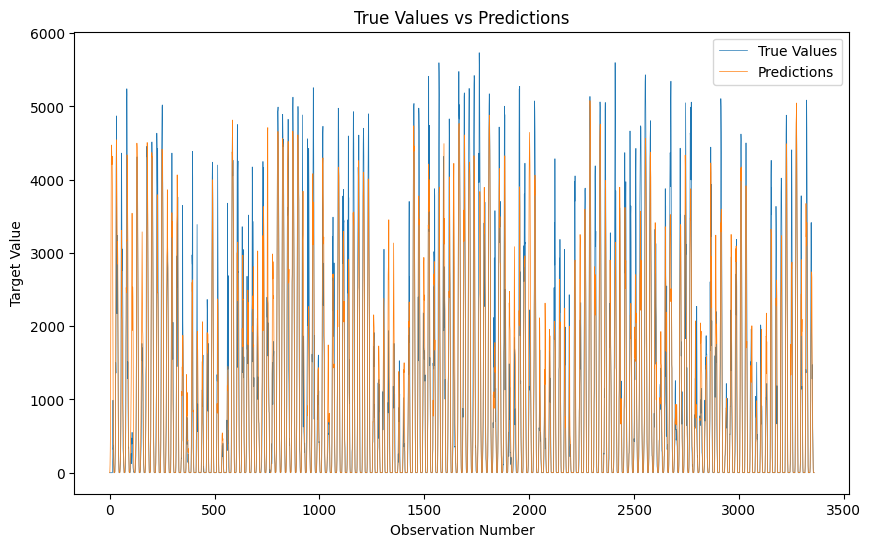

In [10]:
y_pred_A_test = gbm_A.predict(X_val_A)

# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_val_A.reset_index(drop=True), label='True Values', linewidth=0.5)
plt.plot(y_pred_A_test, label='Predictions', linewidth=0.5)
plt.title('True Values vs Predictions')
plt.xlabel('Observation Number')
plt.ylabel('Target Value')
plt.legend()
plt.savefig('true_vs_pred.png')
plt.show()

In [ ]:
test_A.describe()

In [13]:
# Create submission

output_file = 'LGBM_submission.csv'

pred_A = gbm_A.predict(test_A)
pred_B = gbm_B.predict(test_B)
pred_C = gbm_C.predict(test_C)

pred_A = np.clip(pred_A, 0, None)
pred_B = np.clip(pred_B, 0, None)
pred_C = np.clip(pred_C, 0, None)

# Concatenate predictions
predictions = np.concatenate([pred_A, pred_B, pred_C])

# Create an id array
ids = np.arange(0, len(predictions))

# Create a DataFrame
df = pd.DataFrame({
    'id': ids,
    'prediction': predictions
})

# Save to CSV
df.to_csv(output_file, index=False)
print(f"Submission saved to {output_file}")

Submission saved to LGBM_submission.csv


In [ ]:

pred_A = gbm_A.predict(X_val_A)
fig, ax = plt.subplots()
PredictionErrorDisplay.from_predictions(y_val_A, pred_A, ax=ax)
ax.plot([y_val_A.min(), y_val_A.max()], [y_val_A.min(), y_val_A.max()], '--r', linewidth=2)
ax.set_title('Prediction Error Plot')
ax.set_xlabel('True Values')
ax.set_ylabel('Predicted Values')
plt.show()

In [ ]:
gbm_A.params